In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv('../400_sample_labelled_india.csv')
data.dtypes

index                 int64
Text                 object
pos_tagged_words     object
new_languages        object
words_list           object
new_text             object
scores               object
compound            float64
sentiment_vader      object
Unnamed: 9          float64
Unnamed: 10         float64
Unnamed: 11         float64
Unnamed: 12         float64
Unnamed: 13         float64
Unnamed: 14         float64
dtype: object

In [3]:
# Label Encoding...

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(data.sentiment_vader)
data['categorical_label'] = le.transform(data.sentiment_vader)
data.head()

,index,Text,pos_tagged_words,new_languages,words_list,new_text,scores,compound,sentiment_vader,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,categorical_label
0,57000,kalau aku jadi anti vaccine ni salahkan keraja...,"[('if', 'IN'), ('i', 'JJ'), ('become', 'VBP'),...",ENGLISH,"['become', 'anti', 'vaccine', 'blame', 'malays...",become anti vaccine blame malaysian government...,"{'neg': 0.095, 'neu': 0.905, 'pos': 0.0, 'comp...",-0.3182,negative,NaN,NaN,NaN,NaN,NaN,NaN,0
1,57003,"""no vax passports"": anti-vaccine protesters ga...","[('no', 'DT'), ('van', 'NN'), ('passports', 'V...",ENGLISH,"['van', 'passports', 'anti', 'vaccine', 'prote...",van passports anti vaccine protester gather sp...,"{'neg': 0.339, 'neu': 0.661, 'pos': 0.0, 'comp...",-0.4767,negative,NaN,NaN,NaN,NaN,NaN,NaN,0
2,57044,"myself, my lovely wife &amp; respectful parent...","[('myself', 'PRP'), ('my', 'PRP$'), ('lovely',...",ENGLISH,"['lovely', 'wife', 'amp', 'respectful', 'paren...",lovely wife amp respectful parent complete tak...,"{'neg': 0.075, 'neu': 0.424, 'pos': 0.501, 'co...",0.9801,positive,NaN,NaN,NaN,NaN,NaN,NaN,2
3,57046,finally india is getting out second wave these...,"[('finally', 'RB'), ('india', 'NN'), ('is', 'V...",ENGLISH,"['finally', 'india', 'get', 'second', 'wave', ...",finally india get second wave moron start spre...,"{'neg': 0.252, 'neu': 0.667, 'pos': 0.081, 'co...",-0.7334,negative,NaN,NaN,NaN,NaN,NaN,NaN,0
4,57049,sc: politicians who run politics as business r...,"[('so', 'RB'), ('politicians', 'NNS'), ('who',...",ENGLISH,"['politician', 'run', 'politic', 'business', '...",politician run politic business engage anti na...,"{'neg': 0.208, 'neu': 0.727, 'pos': 0.065, 'co...",-0.7067,negative,NaN,NaN,NaN,NaN,NaN,NaN,0


In [4]:
#Separating the input feature and label

X=data.words_list
y=data.categorical_label

In [5]:
# Preparing the input features for training
# We convert the text words into arrays form.
# Maximum 500 features/words selected for training. 
# These 500 words will be selected on the importance that will distinguish between positive tweets and negative tweets.

max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)


In [6]:
# Separating the 70% data for training data and 30% for testing data

X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)


In [7]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

In [8]:
# Model compilation
# First, we are calling the model
# We are using 2 classes so we set “binary_crossentropy” 
# and if we use more than two classes then we use “categorical_crossentropy”
# The optimizer is a function that used to change the features of the neural network
#  such as learning rate (how the model learns with features) in order to reduce the losses.
#  So the learning rate of the neural networks to reduce the losses is defined by the optimizer.
# We are setting metrics=accuracy because we are going to calculate the
#  percentage of correct predictions overall predictions on the validation set

model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

2022-03-10 20:56:04.025800: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Batch size =80 so the model takes 80 tweets in each iteration and train them.
# Epochs =6 so the model will train on the data 6 times. Epoch is a term used in machine learning and indicates the number of passes of the entire training dataset the machine learning algorithm has completed.
history=model.fit(X_train,Y_train,batch_size=80,epochs=6, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/6
4/4 [==============================] - 7s 2s/step - loss: 0.6281 - accuracy: 0.4405 - val_loss: -0.0606 - val_accuracy: 0.4286
Epoch 2/6
4/4 [==============================] - 2s 599ms/step - loss: -0.3874 - accuracy: 0.3889 - val_loss: -0.9535 - val_accuracy: 0.4286
Epoch 3/6
4/4 [==============================] - 2s 428ms/step - loss: -0.7297 - accuracy: 0.3889 - val_loss: -1.1321 - val_accuracy: 0.4286
Epoch 4/6
4/4 [==============================] - 1s 281ms/step - loss: -0.7485 - accuracy: 0.3889 - val_loss: -1.4938 - val_accuracy: 0.4286
Epoch 5/6
4/4 [==============================] - 1s 345ms/step - loss: -1.0401 - accuracy: 0.3889 - val_loss: -1.7856 - val_accuracy: 0.4286
Epoch 6/6
4/4 [==============================] - 1s 261ms/step - loss: -1.1604 - accuracy: 0.3889 - val_loss: -2.0535 - val_accuracy: 0.4286
Training finished !!


In [10]:
# Testing the Trained model on test data
# Getting predictions/classifying the sentiments (positive/negative) on the test data using the trained model.

accr1 = model.evaluate(X_test,Y_test) #we are starting to test the model here


4/4 [==============================] - 0s 43ms/step - loss: -3.2492 - accuracy: 0.3750


In [11]:
print("Test set\n Accuracy: {:0.2f}".format(accr1[1])) 

Test set
 Accuracy: 0.38


In [12]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5)


confusion matrix 

[[ 0 24  0]
 [ 0 45  0]
 [ 0 51  0]]


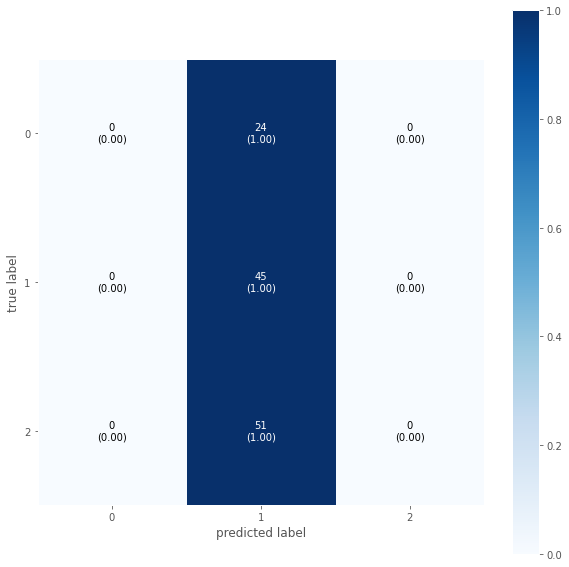

In [13]:
#confusion matrix

print('confusion matrix \n')
CR = confusion_matrix(Y_test, y_pred)
print(CR)

fig,ax = plot_confusion_matrix(conf_mat=CR, figsize=(10,10),
                                show_absolute=True, show_normed=True,
                                colorbar=True)

plt.show()
